In [76]:
import dalex as dx
from sklearn.tree import DecisionTreeClassifier
from interpret.glassbox import ExplainableBoostingClassifier
from interpret.glassbox import DecisionListClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB


clfs = {
    "CART": DecisionTreeClassifier(random_state=1234),
    "EBM": ExplainableBoostingClassifier(),
    "LR_l2": LogisticRegression(penalty="l2",random_state=1234),
    "GNB": GaussianNB(),
    "LR": LogisticRegression(penalty="none", random_state=1234),
    "DL": DecisionListClassifier(random_state=1234) 
}

datasets = ['breast', 'campus', 'churn', 'climate',
            'compas', 'diabetes', 'german', 'heart',
            'adult', 'student', 'bank', 'credit']

In [77]:
from sklearn.base import clone 
from sklearn import metrics
import pandas as pd

import helper
import importlib
importlib.reload(helper)
from sklearn.pipeline import make_pipeline

dataset = "heart"

from sklearn.model_selection import train_test_split

X=pd.read_csv(f"./datasets/cleaned/{dataset}_X.csv")
X = X.drop("Unnamed: 0", axis=1)
y = pd.read_csv(f"./semi-syntetic_dataset/CART/{dataset}_y.csv")

features_types_df = pd.read_csv(f"./datasets/cleaned/datatypes/{dataset}.csv")

feature_inidices = list(map(int, list(features_types_df)))
features_names = list(features_types_df.T[0])
features_types = list(map(int, list(features_types_df.T[1])))

preprocess = helper.select_preprocessing_for_many_feat(feature_inidices, features_types, features_names)

In [78]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [79]:
clfs["LR"]

LogisticRegression(penalty='none', random_state=1234)

In [80]:
heart_lr = make_pipeline(
    preprocess,
    clfs["EBM"]
)
heart_lr.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Sex', 'cp', 'Place']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['Age', 'trestbps', 'chol',
                                                   'fbs', 'restecg', 'thalach',
                                                   'exang', 'oldpeak'])])),
                ('explainableboostingclassifier',
                 ExplainableBoostingClassifier(feature_names=['fe...
                                                              'categorical',
                                                              'categorical',
         

In [81]:
heart_cart = make_pipeline(
    preprocess,
    clfs["CART"]
)
heart_cart.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Sex', 'cp', 'Place']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['Age', 'trestbps', 'chol',
                                                   'fbs', 'restecg', 'thalach',
                                                   'exang', 'oldpeak'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=1234))])

In [82]:
heart_lr_exp = dx.Explainer(heart_lr, X, y,
                            label="Heart LR pipeline"
)

Preparation of a new explainer is initiated

  -> data              : 457 rows 11 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 457 values
  -> model_class       : interpret.glassbox.ebm.ebm.ExplainableBoostingClassifier (default)
  -> label             : Heart LR pipeline
  -> predict function  : <function yhat_proba_default at 0x7f2dc844c700> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0191, mean = 0.457, max = 0.977
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.908, mean = 0.00202, max = 0.913
  -> model_info        : package sklearn

A new explainer has been created!


In [83]:
heart_cart_exp = dx.Explainer(heart_cart, X, y,
                            label="Heart CART pipeline"
)

Preparation of a new explainer is initiated

  -> data              : 457 rows 11 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 457 values
  -> model_class       : sklearn.tree._classes.DecisionTreeClassifier (default)
  -> label             : Heart CART pipeline
  -> predict function  : <function yhat_proba_default at 0x7f2dc844c700> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0, mean = 0.46, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = 0.0, mean = 0.0, max = 0.0
  -> model_info        : package sklearn

A new explainer has been created!


In [84]:
pd_lr = heart_lr_exp.model_profile(variables=["Age", "chol"])
pd_lr.result 

Calculating ceteris paribus: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


,_vname_,_label_,_x_,_yhat_,_ids_
0,Age,Heart LR pipeline,28.00,0.467384,0
1,Age,Heart LR pipeline,28.47,0.467384,0
2,Age,Heart LR pipeline,28.94,0.467384,0
3,Age,Heart LR pipeline,29.41,0.467384,0
4,Age,Heart LR pipeline,29.88,0.467384,0
...,...,...,...,...,...
197,chol,Heart LR pipeline,578.88,0.599329,0
198,chol,Heart LR pipeline,584.91,0.599329,0
199,chol,Heart LR pipeline,590.94,0.599329,0
200,chol,Heart LR pipeline,596.97,0.599329,0


In [85]:
pd_lr_cat = heart_lr_exp.model_profile(variable_type="categorical")
pd_lr_cat.plot()

Calculating ceteris paribus: 100%|██████████| 11/11 [00:10<00:00,  1.07it/s]


In [86]:
pd_cart = heart_cart_exp.model_profile(variables=["Age", "chol"])
pd_cart.result 

Calculating ceteris paribus: 100%|██████████| 2/2 [00:00<00:00, 14.60it/s]


,_vname_,_label_,_x_,_yhat_,_ids_
0,Age,Heart CART pipeline,28.00,0.486667,0
1,Age,Heart CART pipeline,28.47,0.486667,0
2,Age,Heart CART pipeline,28.94,0.486667,0
3,Age,Heart CART pipeline,29.41,0.486667,0
4,Age,Heart CART pipeline,29.88,0.486667,0
...,...,...,...,...,...
197,chol,Heart CART pipeline,578.88,0.596667,0
198,chol,Heart CART pipeline,584.91,0.596667,0
199,chol,Heart CART pipeline,590.94,0.596667,0
200,chol,Heart CART pipeline,596.97,0.596667,0


In [87]:
pd_lr.plot()
pd_cart.plot()

In [88]:
pd_cart.result["_yhat_"]

0      0.486667
1      0.486667
2      0.486667
3      0.486667
4      0.486667
         ...   
197    0.596667
198    0.596667
199    0.596667
200    0.596667
201    0.596667
Name: _yhat_, Length: 202, dtype: float64

In [90]:
pdp_lr = heart_lr_exp.model_profile()
pdp_cart = heart_cart_exp.model_profile()

Calculating ceteris paribus: 100%|██████████| 11/11 [00:00<00:00, 21.29it/s]


In [91]:
pdp_cart.plot(pdp_lr, variables=["Age", "chol"])


In [97]:
pdp_cart.plot(pdp_lr, variable_type="categorical", variables="Sex")

TypeError: plot() got an unexpected keyword argument 'variable_type'

/home/bart/anaconda3/envs/mainenv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning:

The handle <matplotlib.lines.Line2D object at 0x7f2db19e9640> has a label of '_x_' which cannot be automatically added to the legend.

/home/bart/anaconda3/envs/mainenv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning:

The handle <matplotlib.lines.Line2D object at 0x7f2db19e9970> has a label of '_yhat_' which cannot be automatically added to the legend.

/home/bart/anaconda3/envs/mainenv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning:

The handle <matplotlib.lines.Line2D object at 0x7f2db19e9d30> has a label of '_ids_' which cannot be automatically added to the legend.



<AxesSubplot:>

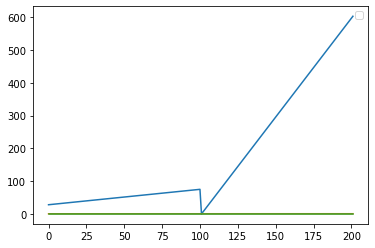

In [99]:
pd_cart.plot()

In [96]:
pdp_cart["Age"]

,_vname_,_label_,_x_,_yhat_,_ids_
0,Age,Heart CART pipeline,28.000,0.483333,0
1,Age,Heart CART pipeline,28.470,0.483333,0
2,Age,Heart CART pipeline,28.940,0.483333,0
3,Age,Heart CART pipeline,29.410,0.483333,0
4,Age,Heart CART pipeline,29.880,0.483333,0
...,...,...,...,...,...
1005,oldpeak,Heart CART pipeline,4.696,0.763333,0
1006,oldpeak,Heart CART pipeline,4.772,0.763333,0
1007,oldpeak,Heart CART pipeline,4.848,0.763333,0
1008,oldpeak,Heart CART pipeline,4.924,0.763333,0
